In [46]:
import os.path
import math 
import itertools

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from snntorch import (
    spikegen,
    spikeplot as splt,
    surrogate,
)
import snntorch as snn

In [73]:
class XC_PBE():
    
  def __init__(self, data):
    
    if 'n' not in data.keys() and 'rs' in data.keys():
      self.rs = data['rs']
      self.n = self._setN()
    if 'rs' not in data.keys() and 'n' in data.keys():
        self.n = data['n']
      self.rs = self._setRS()

    self.kf = self._setKF()

    if 's' not in data.keys() and 'g' in data.keys():
      self.g = data['g']
      self.s = self._setS()
    if 'g' not in data.keys() and 's' in data.keys():
      self.s = data['s']
      self.g = self._setG()

    self.t = self._setT()
    self.gaux = self._setGaux()
    self.ecunif = self._setEcunif()
    self.biga = self._setBiga()
    self.bigh = self._setBigh()
    self.ec = self._setEc()
    self.exunif = self._setExunif()
    self.fx = self._setFx()
    self.ex = self._setEx()
    self.exc = self._setExc()


  def _setN(self):
    return 3.0 / ((4.0 * np.pi) * self.rs**3)


  def _setRS(self):
    return (3.0 / (4.0 * np.pi * self.n))**(1.0 / 3.0)


  def _setKF(self):
    return ((9 * math.pi / 4)**(1.0 / 3.0)) * np.power(self.rs, -1)


  def _setS(self):
    return np.divide(self.g, 2* self.kf * self.n)


  def _setG(self):
    return self.s * (2 * self.kf * self.n)


  def _setT(self):
    a0 = 1
    return np.divide(self.g, 2 * np.sqrt(4 * self.kf / (math.pi * a0)) * self.n)


  def _setGaux(self):
    abeta1 = 7.5957
    abeta2 = 3.5876
    abeta3 = 1.6382
    abeta4 = 0.49294
    app = 1.0
    return abeta1 * np.sqrt(self.rs) + abeta2 * self.rs + abeta3 * (np.power(self.rs, 1.5)) + abeta4 * (np.power(self.rs, app+1))


  def _setEcunif(self):
    aa  = 0.0310907
    aalpha1 = 0.21370
    return -2 * aa * (1 + aalpha1 * self.rs) * np.log(1.0 + (1.0 / (2.0 * aa)) * np.power(self.gaux, -1))


  def _setBiga(self):
    beta = 0.06672455060314922
    gamma = (1 - math.log(2)) / (math.pi**2)
    echarge = 1
    a0 = 1
    return (beta / gamma) * np.power(np.exp(-(self.ecunif * a0) / (gamma * (echarge**2))) -1, -1)


  def _setBigh(self):
    echarge = 1
    a0 = 1
    beta = 0.06672455060314922
    gamma = (1 - math.log(2)) / (math.pi**2)
    return (echarge**2 / a0) * gamma * np.log(1 + (beta / gamma) * (np.power(self.t, 2)) * (np.divide((1 + self.biga * np.power(self.t,2)), (1 + self.biga * np.power(self.t, 2) + np.power(self.biga, 2) * np.power(self.t, 4)))))


  def _setEc(self):
    return self.ecunif + self.bigh


  def _setExunif(self):
    echarge = 1
    return -3 * echarge**2 * self.kf / (4 * math.pi)


  def _setFx(self):
    k = 0.804
    mu = 0.21951
    divisor = 1 + mu * np.power(self.s, 2) / k
    return 1 + k - k * np.power(divisor, -1)


  def _setEx(self):
    return self.exunif * self.fx


  def _setExc(self):
    return self.ex + self.ec


  def getFx(self):
    return self.fx


  def getFxc(self):
    return self.exc / self.exunif
  
  def getExc(self):
    return self.exc

In [78]:
def plot3d(X,Y,Z, x_labels, y_labels, z_labels):
    fig, ax = plt.subplots(figsize=(18,22), subplot_kw={"projection": "3d"})
    ax.set_xlabel(x_labels,fontsize=22)
    ax.set_ylabel(y_labels,fontsize=22)
    ax.set_zlabel(z_labels,fontsize=22)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                   linewidth=0, antialiased=False)

In [71]:
from PBE import XC_PBE

1.7763067209233323

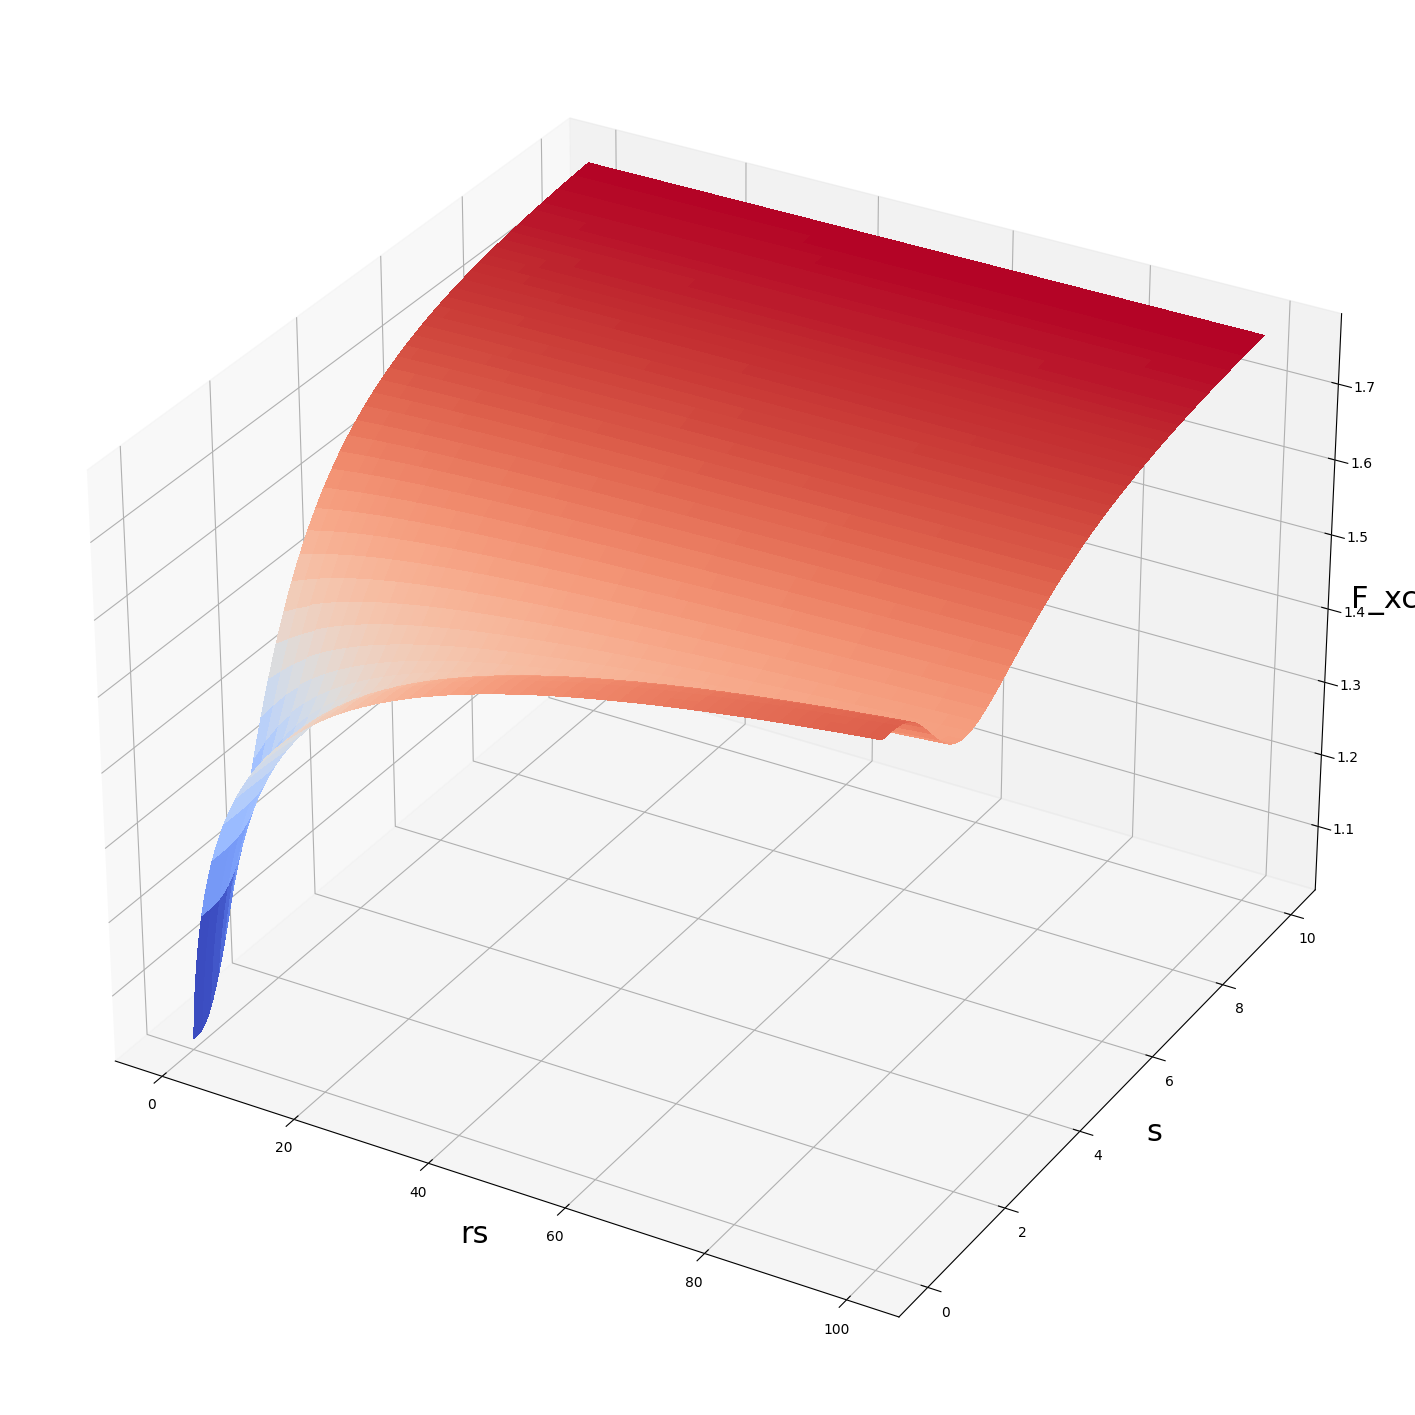

In [81]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
data = {}
rs = np.linspace(0.1000,100, 4096)
s = np.linspace(0,10, 4096)
data['rs'] , data['s'] = np.meshgrid(rs, s, indexing='ij')
inputs = [data['rs'], data['s']]
kf = ((9 * math.pi / 4)**(1.0 / 3.0)) * np.power(data['rs'], -1)
exunif = -3 * kf/(4*np.pi)
n = 3.0 / ((4.0 * np.pi) * rs**3)
labels = XC_PBE(data).exc/exunif
domain_for_inputs_rs = rs
domain_for_inputs_s = s
domain_for_outputs_exc = np.linspace(labels.min(),labels.max(),4096)
#domain_for_outputs = np.linspace(0,1,1000)
plot3d(data['rs'],data['s'], labels, "rs", "s", 'F_xc')
labels.max()

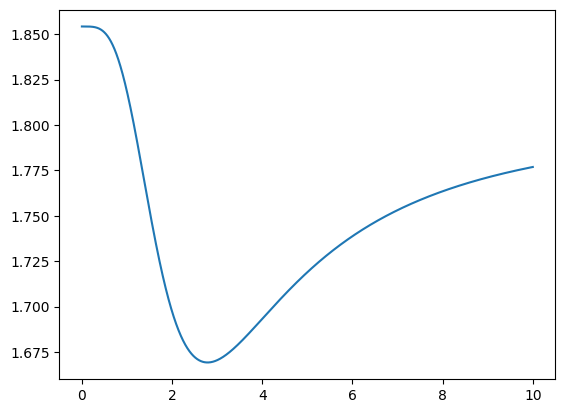

In [63]:
plt.plot(s,labels[-1,:])

In [82]:
import collections
import bisect
import numpy as np

class Gray_Data():
    def __init__(self, domain: np.array, original_data = None, gray_array = None):
        self.domain = domain
        self.mask_for_gray = collections.OrderedDict()
        for index,value in enumerate(self.domain):
            self.mask_for_gray[value] = self.int_to_gray(index)
        self.num_train = int(np.ceil(np.log2(self.domain.shape[0])))
        self.gray_array_for_domain = self._set_gray_array()
        self.domain_list = list(self.mask_for_gray.keys())
        if original_data is not None:
            self.original_data = original_data
            indices = np.searchsorted(self.domain_list, self.original_data)
            self.gray_array = np.take(self.gray_array_for_domain, indices, axis=0)
        if gray_array is not None:
            self.gray_array = gray_array
            out = [self.domain[self.gray_to_int(self.from_array_to_string(j))] for j in self.gray_array]
            self.original_data = np.array(out)

    def int_to_gray(self, x: int) -> str:
        bin_string = f"{x:b}"
        bin_string_2 = '0' + f"{x>>1:b}"
        new = [str((ord(a) ^ ord(b))) for a,b in zip(bin_string, bin_string_2)]
        return "".join(new)

    def gray_to_int(self,n: str) -> int:
        n = int(n, 2)
        mask = n
        while mask != 0:
            mask >>= 1
            n ^= mask
        return int(bin(n)[2:],2)

    def from_string_to_array(self, x): # transforms string gray to array one
        out = np.array(list(x)).astype(int)
        out = np.pad(out, (self.num_train - len(out), 0), 'constant')
        return out

    def from_array_to_string(self, x):
        out = ""
        flag = False
        for i in x:
            if i != 0:
                flag = True
            if flag:
                out += str(int(i))
        if out == "":
            out = "0"
        return out

    def _set_gray_array(self):
        return np.array([self.from_string_to_array(self.mask_for_gray[j]) for j in self.mask_for_gray])

In [83]:
array_path_inputs = f'arrays/gray_inputs_{inputs[0].shape[1]}_{inputs[0].shape[0]}.npy'
if os.path.isfile(array_path_inputs):
    with open(array_path_inputs, "rb") as data:
        gray_inputs = np.load(data)
else:
    gray_inputs_x = Gray_Data(domain = domain_for_inputs_rs, original_data = np.reshape(inputs[0],-1))
    gray_inputs_y = Gray_Data(domain = domain_for_inputs_s, original_data = np.reshape(inputs[1],-1))
    gray_inputs = np.concatenate((gray_inputs_x.gray_array, gray_inputs_y.gray_array), axis = 1)
    with open(array_path_inputs, "wb") as data:
        np.save(data,gray_inputs)

In [ ]:
array_path_labels = f'arrays/gray_labels_{labels.shape[1]}_{labels.shape[0]}.npy'
if os.path.isfile(array_path_labels):
    with open(array_path_labels, "rb") as data:
        gray_labels = np.load(data)
else:
    gray_labels = Gray_Data(domain = domain_for_outputs_exc, original_data = np.reshape(labels,-1)).gray_array
    with open(array_path_labels, "wb") as data:
        np.save(data,gray_labels)

In [ ]:
gray_labels.shape

(16777216, 12)

In [ ]:
shek = Gray_Data(domain = domain_for_outputs_exc, original_data = np.reshape(labels,-1)).original_data
shek = np.reshape(shek,(-1,4096))

In [ ]:
data['rs']

array([[ 0.1       ,  0.1       ,  0.1       , ...,  0.1       ,
         0.1       ,  0.1       ],
       [ 0.10241758,  0.10241758,  0.10241758, ...,  0.10241758,
         0.10241758,  0.10241758],
       [ 0.10483516,  0.10483516,  0.10483516, ...,  0.10483516,
         0.10483516,  0.10483516],
       ...,
       [ 9.99516484,  9.99516484,  9.99516484, ...,  9.99516484,
         9.99516484,  9.99516484],
       [ 9.99758242,  9.99758242,  9.99758242, ...,  9.99758242,
         9.99758242,  9.99758242],
       [10.        , 10.        , 10.        , ..., 10.        ,
        10.        , 10.        ]])

In [ ]:
shek

array([[-4.70253161, -4.70253161, -4.70253161, ..., -4.70253331,
        -4.70253331, -4.70253331],
       [-4.59368702, -4.59368702, -4.59368702, ..., -4.59368898,
        -4.59368898, -4.59368898],
       [-4.4898475 , -4.4898475 , -4.4898475 , ..., -4.48984975,
        -4.48984975, -4.48984975],
       ...,
       [-0.06441679, -0.07210419, -0.07611128, ..., -0.08268887,
        -0.08268887, -0.08268887],
       [-0.0644028 , -0.072093  , -0.07609782, ..., -0.08266888,
        -0.08266888, -0.08266888],
       [-0.06438882, -0.07208182, -0.07608435, ..., -0.0826489 ,
        -0.0826489 , -0.0826489 ]])

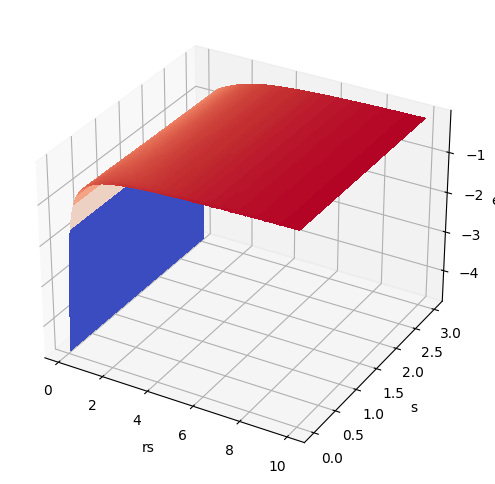

In [ ]:
plot3d(data['rs'],data['s'], shek, "rs", "s", 'exc')

In [ ]:
etalon_rs = data['rs']
etalon_s = data['s']

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def shek_func(rs_arr,s_arr):
    out = []
    for rs,s in zip(rs_arr,s_arr):
        ind_rs = find_nearest(etalon_rs[:,0],rs)
        ind_s = find_nearest(etalon_s[0,:],s)
        out.append(shek[ind_rs,ind_s])
    return np.array(out)
    

In [ ]:
a = (5,4)

In [ ]:
shek_func([140,2,4],[4,200,2])

array([-0.0826489 , -0.4012224 , -0.20605551])

In [86]:
from torch.utils.data import Dataset

class DatasetPBE(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = torch.from_numpy(np.asarray(inputs, dtype=float)).type(torch.float) 
        self.labels = torch.from_numpy(np.asarray(labels, dtype=float)).type(torch.float) 
      
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [97]:
NUM_STEPS = 15 # число таймстепов у спайков (лучше брать нечетным, чтобы однозначно понимать больше или меньше половины спайков нагенерилось)
beta = 0.9
num_inputs = gray_inputs.shape[1]
num_hidden = 1024
num_outputs = gray_labels.shape[1]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, learn_threshold = True, learn_beta = True, spike_grad = surrogate.fast_sigmoid()) #учим все параметры + указываем явно сурогатный градиент
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, learn_beta = True, learn_threshold = True, spike_grad = surrogate.fast_sigmoid())
        self.fc3 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, learn_beta = True, learn_threshold = True, spike_grad = surrogate.fast_sigmoid())
        # self.lif2 = snn.Leaky(beta=beta)
        # self.fc3 = nn.Linear(num_hidden, num_hidden)
        # self.lif3 = snn.Leaky(beta=beta)
        #self.fc4 = nn.Linear(num_hidden, num_outputs)
        # self.fc4 = nn.Linear(num_hidden, num_hidden)
        # self.lif4 = snn.Leaky(beta=beta)
        # self.fc5 = nn.Linear(num_hidden, num_hidden)
        # self.lif5 = snn.Leaky(beta=beta)
        # self.fc6 = nn.Linear(num_hidden, num_hidden)
        # self.lif6 = snn.Leaky(beta=beta)
        # self.fc7 = nn.Linear(num_hidden, num_hidden)
        # self.lif7 = snn.Leaky(beta=beta)
        # self.fc8 = nn.Linear(num_hidden, num_hidden)
        # self.lif8 = snn.Leaky(beta=beta)
        # self.fc9 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        # mem3 = self.lif3.init_leaky()
        # mem4 = self.lif4.init_leaky()
        # mem5 = self.lif5.init_leaky()
        # mem6 = self.lif6.init_leaky()
        # mem7 = self.lif7.init_leaky()
        # mem8 = self.lif8.init_leaky()
        # Record the final layer
        # spk3_rec = []
        # mem3_rec = []
        # cur4_rec = []
        # spk8_rec = []
        # mem8_rec = []
        # cur9_rec = []
        spk3_rec = []
        mem3_rec = []


        for step in range(NUM_STEPS):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            # cur3 = self.fc3(spk2)
            # spk3, mem3 = self.lif3(cur3, mem3)
            # cur4 = self.fc4(mem3)
            # cur4 = self.fc4(spk3)
            # spk4, mem4 = self.lif4(cur4, mem4)
            # cur5 = self.fc5(spk4)
            # spk5, mem5 = self.lif5(cur5, mem5)
            # cur6 = self.fc6(spk5)
            # spk6, mem6 = self.lif6(cur6, mem6)
            # cur7 = self.fc7(spk6)
            # spk7, mem7 = self.lif7(cur7, mem7)
            # cur8 = self.fc8(spk7)
            # spk8, mem8 = self.lif8(cur8, mem8)
            # cur9 = self.fc9(mem8)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

            # spk3_rec.append(spk3)
            # mem3_rec.append(mem3)
            # cur4_rec.append(cur4)

        # return torch.stack(cur4_rec, dim=0), torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
net = Net().to(device)

In [98]:
def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.5f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.5f}")
    print("\n")

In [99]:
dataset = DatasetPBE(gray_inputs, gray_labels)
train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_batch_size = len(train_set)//1000
test_batch_size = len(test_set)//1000
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=True, drop_last=True)



In [128]:
loss_hist = []
test_loss_hist = []
current_epoch = 0
counter = 0
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
dtype = torch.float
name = 'nn_state/neuromorphiс'
if os.path.isfile(name):
    load = torch.load(name)
    net.load_state_dict(load['state_dict'])
    optimizer.load_state_dict(load['optimizer'])
    loss_hist = load['train_history']
    test_loss_hist = load['test_history']
    current_epoch = load['epoch']
    counter = load['counter']

In [129]:
num_epochs = 14
for epoch in range(current_epoch,num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)
        net.train()
        spk_rec, mem_rec = net(data.view(train_batch_size, -1))
        loss_val = loss(spk_rec.sum(dim = 0) - NUM_STEPS/2, targets)
        l2_reg = torch.tensor(0.).to(device)
        l2_lambda = 0#0.01
        for param in net.parameters():
            l2_reg += torch.norm(param)
        loss_val += l2_lambda * l2_reg
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        loss_hist.append((loss_val-l2_lambda * l2_reg).item())
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            test_spk, test_mem = net(test_data.view(test_batch_size, -1))
            test_loss = loss(test_spk.sum(dim = 0)  - NUM_STEPS/2, test_targets)
            l2_reg = torch.tensor(0.).to(device)
            l2_lambda = 0#0.01
            for param in net.parameters():
                l2_reg += torch.norm(param)
            test_loss += l2_lambda * l2_reg
            test_loss_hist.append((test_loss-l2_lambda * l2_reg).item())
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1
current_epoch = epoch
print(l2_reg)

Epoch 10, Iteration 0
Train Set Loss: 0.07994
Test Set Loss: 0.08540


Epoch 10, Iteration 50
Train Set Loss: 0.08270
Test Set Loss: 0.08330


Epoch 10, Iteration 100
Train Set Loss: 0.08050
Test Set Loss: 0.08167


Epoch 10, Iteration 150
Train Set Loss: 0.08254
Test Set Loss: 0.08715


Epoch 10, Iteration 200
Train Set Loss: 0.08262
Test Set Loss: 0.08457


Epoch 11, Iteration 350
Train Set Loss: 0.07903
Test Set Loss: 0.07903


Epoch 11, Iteration 400
Train Set Loss: 0.08003
Test Set Loss: 0.07999


Epoch 11, Iteration 450
Train Set Loss: 0.07841
Test Set Loss: 0.08119


Epoch 11, Iteration 500
Train Set Loss: 0.07697
Test Set Loss: 0.08191


Epoch 11, Iteration 550
Train Set Loss: 0.07763
Test Set Loss: 0.07894


Epoch 11, Iteration 600
Train Set Loss: 0.07873
Test Set Loss: 0.08038


Epoch 11, Iteration 650
Train Set Loss: 0.07728
Test Set Loss: 0.07548


Epoch 11, Iteration 700
Train Set Loss: 0.07958
Test Set Loss: 0.07855


Epoch 11, Iteration 750
Train Set Loss: 0.08045
Test S

In [130]:
def save_results(model, optimizer, loss_hist, test_loss_hist, file_name, epoch, counter):
  state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'train_history': loss_hist,
    'test_history': test_loss_hist,
    'counter': counter}
  torch.save(state, file_name)

In [131]:
save_results(net, optimizer, loss_hist, test_loss_hist, name, num_epochs, counter)

In [132]:
def nn_forward(rs,s, domain_for_inputs_rs, domain_for_inputs_s, domain_for_outputs_exc, device, net):
    with torch.no_grad():
        rs_for_NN = np.where(rs < domain_for_inputs_rs.max(), rs, domain_for_inputs_rs.max())    
        s_for_NN = np.where(s < domain_for_inputs_s.max(), s, domain_for_inputs_s.max())
        gray_inputs_rs = Gray_Data(domain = domain_for_inputs_rs, original_data = rs_for_NN)
        gray_inputs_s = Gray_Data(domain = domain_for_inputs_s, original_data = s_for_NN)
        gray_inputs = torch.from_numpy(np.concatenate((gray_inputs_rs.gray_array, gray_inputs_s.gray_array), axis = 1).astype(np.float32)).to(device)
        spk, mem = net(gray_inputs)
        out = np.reshape(((spk.mean(dim = 0)  > 0.5) * 1.).cpu().detach().numpy(), 
                         (-1,gray_labels.shape[1]),
                         order = "F")
        out_exc = Gray_Data(domain = domain_for_outputs_exc, gray_array = out).original_data
        return out_exc

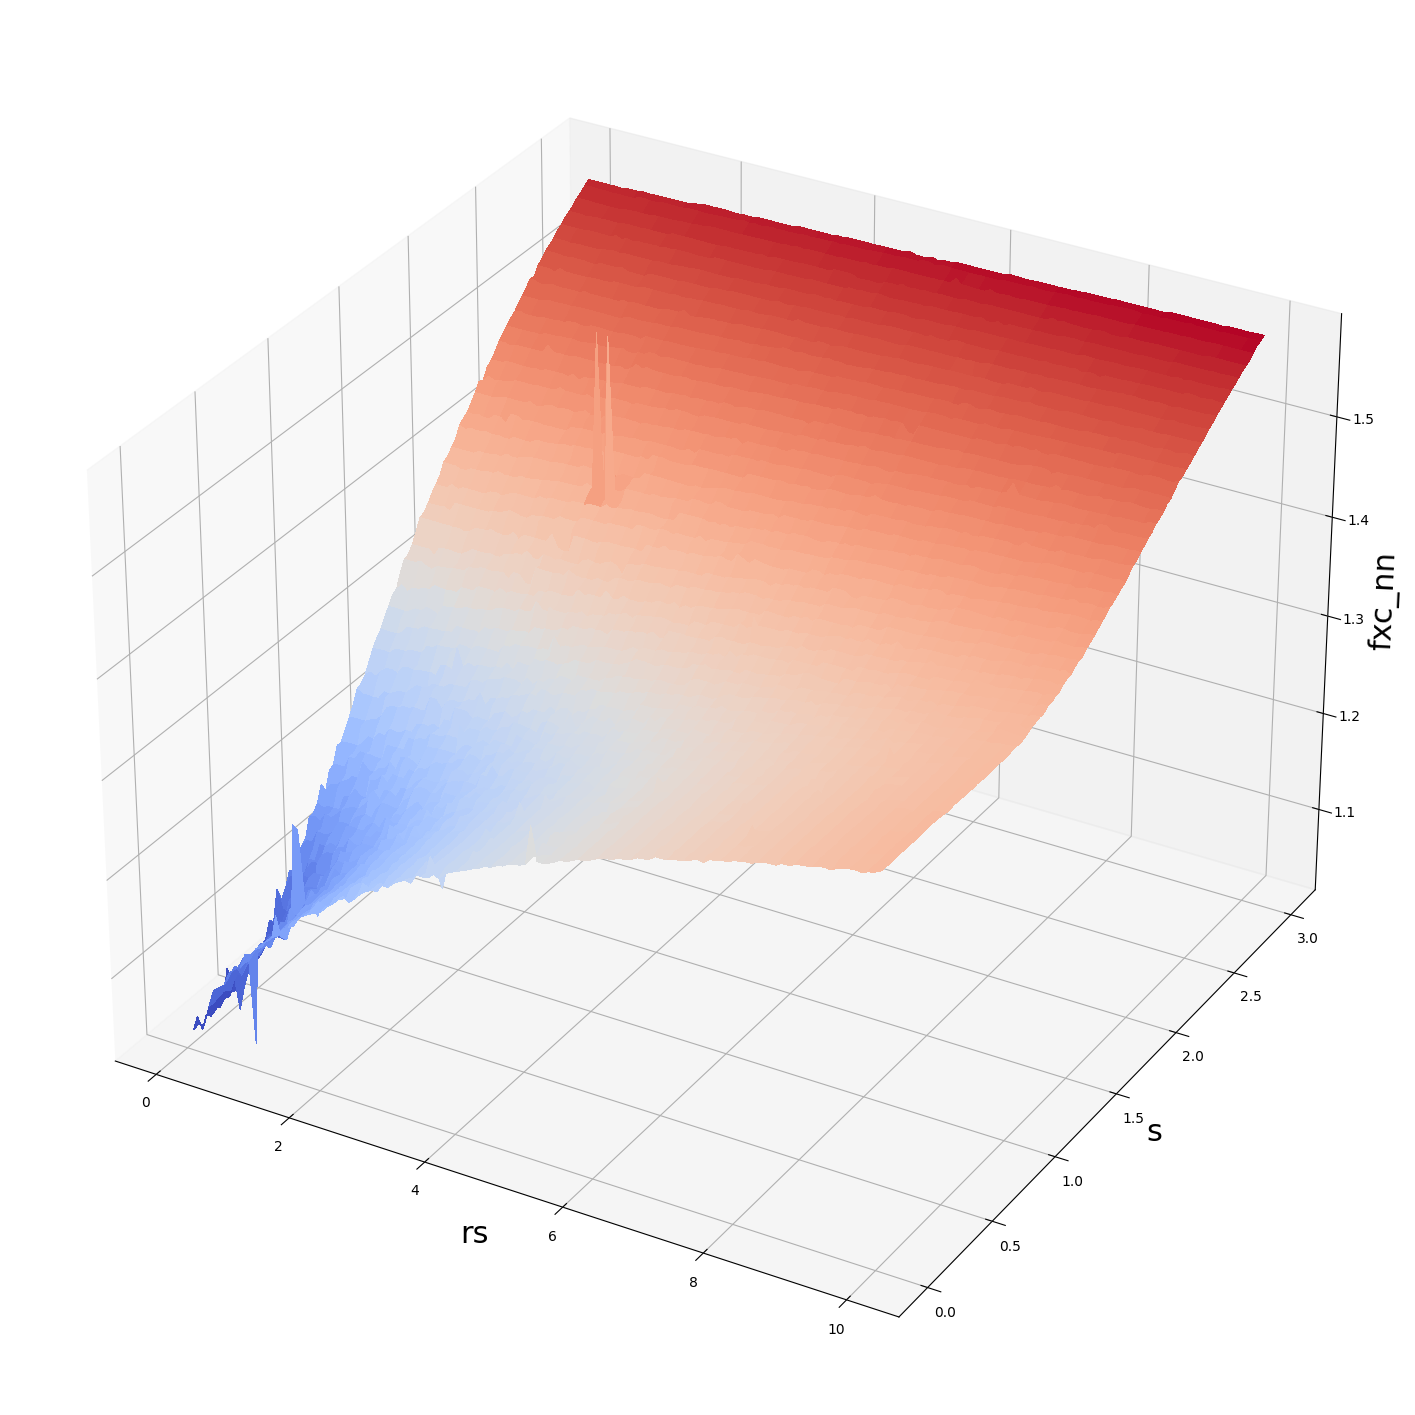

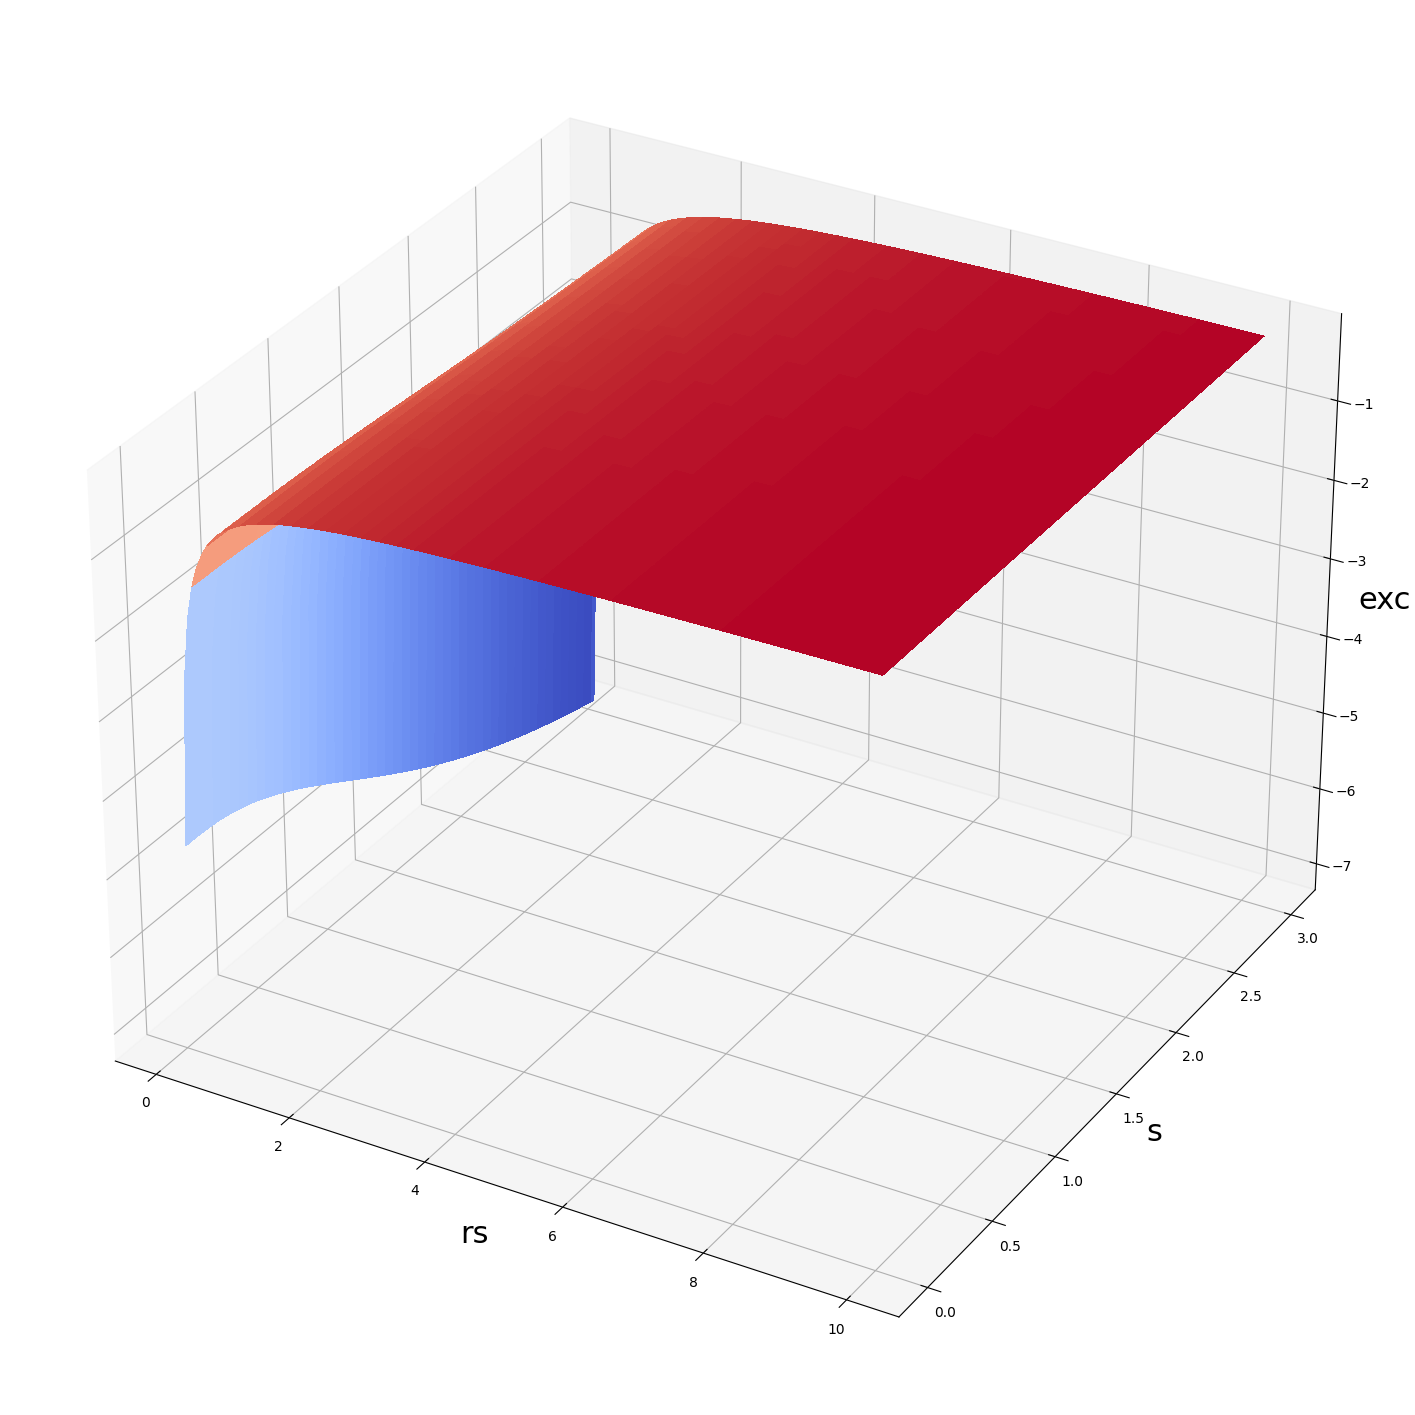

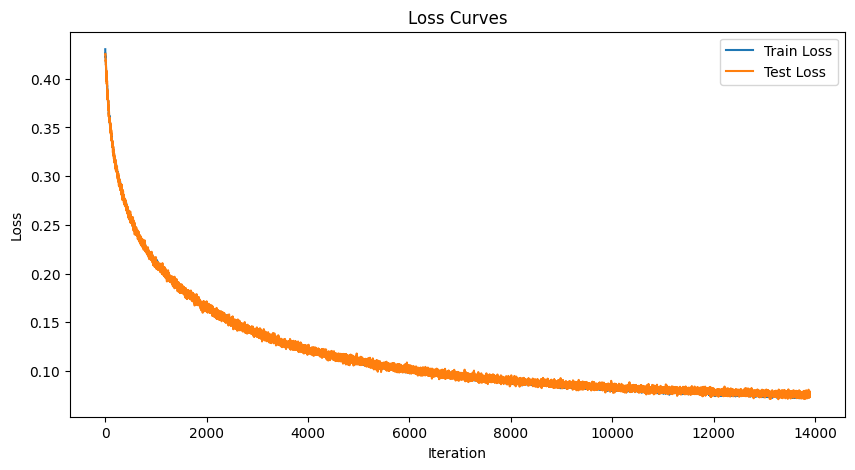

In [137]:
data_check = {}
points_in_data_for_rs = 120
points_in_data_for_s = 100
data_check['rs'] , data_check['s'] = np.meshgrid(np.linspace(0.1, 10, points_in_data_for_rs), np.linspace(0.001, 3, points_in_data_for_s), indexing='ij')
xc = XC_PBE(data_check)
exc = xc.exc
inputs_to_check = [data_check['rs'], data_check['s']]
nn_exc = nn_forward(np.reshape(data_check['rs'], -1),np.reshape(data_check['s'], -1), domain_for_inputs_rs, domain_for_inputs_s, domain_for_outputs_exc, device, net)
out_exc = np.reshape(nn_exc, (points_in_data_for_rs,points_in_data_for_s))
plot3d(inputs_to_check[0],inputs_to_check[1], out_exc, "rs", "s", 'fxc_nn')
plot3d(inputs_to_check[0],inputs_to_check[1], exc, "rs", "s", 'exc')


#import pandas as pd
#toCSV = {}
#toCSV['s'] = data['s'].flatten()
#toCSV['Fx'] = out_check.mean(dim = 0).cpu().detach().numpy().flatten()
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist[100:])
plt.plot(test_loss_hist[100:])
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig(name + '_loss.png')

In [163]:
pip install pyscf

Note: you may need to restart the kernel to use updated packages.


In [138]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

import math 
import numpy as np
from pyscf import gto, dft

In [168]:
mol = gto.M(atom = 'He 3 0 2.82', basis = 'ccpvdz', verbose = 4)

System: uname_result(system='Linux', node='a002s2', release='4.15.0-72-generic', version='#81-Ubuntu SMP Tue Nov 26 12:20:02 UTC 2019', machine='x86_64')  Threads 4
Python 3.9.16 (main, Jan 11 2023, 16:05:54) 
[GCC 11.2.0]
numpy 1.24.2  scipy 1.10.1
Date: Tue Apr 11 17:18:47 2023
PySCF version 2.1.1
PySCF path  /mnt/2tb/rumiantsev/anaconda3/envs/check/lib/python3.9/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 1
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 He     3.000000000000   0.000000000000   2.820000000000 AA    5.669178373695   0.000000000000   5.329027671273 Bohr   0.0

nuclear repulsion = 0
number of shells = 3
number of NR pGTOs = 7
number of NR cGTOs = 5
basis = ccpvdz
ecp = {}
CPU tim

In [144]:
from PBE import XC_PBE

In [162]:
def eval_xc(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    rho0, dx, dy, dz = rho[:4]
    rho0 += 1e-20
    gamma = (dx ** 2 + dy ** 2 + dz ** 2) + 1e-20
    rs = (3/(4 * np.pi * rho0)) ** (1/3)
    kf = (9*np.pi/4) ** (1/3) / rs
    s = gamma/(2 *kf * rho0)
    small_step = 1e-10
    #rs_delta = rs + small_step  
    #s_delta = s + small_step
    data = {}
    data_s = {}
    data_rs = {}
    data["rs"] = rs
    data["s"] = s
    data_s['rs'] = rs
    data_s['s'] = s + small_step
    data_rs['rs'] = rs + small_step
    data_rs['s'] = s
    exunif = -3 * kf/(4*np.pi)
    fxc = nn_forward(rs, s, domain_for_inputs_rs, domain_for_inputs_s, domain_for_outputs_exc, device, net)
    exc = fxc * exunif
    #data_n = {}
    #data_g = {}
    #data_g['n'] = rho0
    #data_g['g'] = gamma + small_step
    #data_n['n'] = rho0 + small_step
    #data_n['g'] = gamma
    #data["rs"] = rs
    #data["s"] = s
    #data_s['rs'] = rs
    #data_s['s'] = s + small_step
    #data_rs['rs'] = rs + small_step
    #data_rs['s'] = s
    #check = XC_PBE(data).exc
    #exc = np.where((rs > 100) | (s > 300),XC_PBE(data).exc,shek_func(rs,s))#XC_PBE(data).exc#nn_forward(rs,s, domain_for_inputs_rs, domain_for_inputs_s, domain_for_outputs_exc, device, net)#
    #exc_rs = shek_func(rs+small_step,s)#XC_PBE(data_rs).exc#nn_forward(rs + small_step,s, domain_for_inputs_rs, domain_for_inputs_s, domain_for_outputs_exc, device, net)#
    #exc_s = shek_func(rs, s + small_step)#XC_PBE(data_s)#nn_forward(rs,s + small_step, domain_for_inputs_rs, domain_for_inputs_s, domain_for_outputs_exc, device, net)#
    #exc_n = XC_PBE(data_n).exc
    #exc_g = XC_PBE(data_g).exc
    #exc = (-3 * kf / (4 * math.pi)) * out_data
    #kf_rs = (9*np.pi/4) ** (1/3) / rs_delta
    #exc_rs = (-3 * kf_rs / (4 * math.pi)) * out_data_rs
    #exc_s = (-3 * kf / (4 * math.pi)) * out_data_s  
    #exc = XC_PBE(data).getExc() 
    #data_rs["rs"] = rs + small_step
    #data_rs["s"] = s 
    #exc_rs = XC_PBE(data_rs).getExc()
    #exc_drs = (exc_rs - exc)/small_step
    #exc_dn = (exc_n - exc)/small_step
    #data_s["rs"] = rs 
    #data_s["s"] = s + small_step 
    #exc_s = XC_PBE(data_s).getExc() 
    #exc_ds = (exc_s - exc)/small_step
    #exc_dg = (exc_g - exc)/small_step
    vrho = XC_PBE(data_rs).vrho#-((1/rho0)**(1/3))/(6 ** (2/3) * np.pi ** (1/3)) * exc_drs - exc_ds * (2*gamma/(3*3**(1/3)*np.pi**(2/3)*rho0**(4/3))) + exc #rho0 * exc_dn + exc#
    vgamma = XC_PBE(data_rs).vgamma#exc_ds/((2*kf)) # rho0 * exc_dg
    vlapl = None
    vtau = None
    vxc = (vrho, vgamma, vlapl, vtau)
    fxc = None
    kxc = None
    #plt.scatter(rs,exc)
    #plt.scatter(rs,check)
    #plt.show()
    return exc, vxc, fxc, kxc
mf = dft.RKS(mol)
mf.grids.level = 0
dft.libxc.define_xc_(mf._numint, eval_xc, xctype='GGA')
mf.conv_tol = 1e-7
mf.kernel()



******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-07
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /mnt/2tb/rumiantsev/notebooks/spiking_baseline/tmp6s71eist
max_memory 4000 MB (current use 15011 MB)
XC library pyscf.dft.libxc version 5.2.0
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (2018)
XC functionals = LDA,VWN
    P. A. M. Dirac, Math. Proc. Cambridge Philos. Soc. 26, 376 (1930)
    F. Bloch, Z. Phys. 57, 545 (1929)
    S. H. Vosko, L. Wilk, and M. Nusair, Can. J. Phys. 58, 1200 (1980)
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids
    
becke partition: Becke, JCP 88, 2547 (1988); DOI:10.1063/1.454033
pruning grids: <function nwchem_prune at 0x7f010e059790>
grid

-644.5385523307908

In [ ]:
-100.32241845070203

In [169]:
mf = dft.RKS(mol)
#mf.grids.level = 0
#mf.conv_tol = 1e-7
mf.xc = "PBE"
mf.kernel()



******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /mnt/2tb/rumiantsev/notebooks/spiking_baseline/tmpafyhrn4n
max_memory 4000 MB (current use 15012 MB)
XC library pyscf.dft.libxc version 5.2.0
    S. Lehtola, C. Steigemann, M. J. Oliveira, and M. A. Marques, SoftwareX 7, 1 (2018)
XC functionals = PBE
    J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 78, 1396 (1997)
    J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof, Phys. Rev. Lett. 78, 1396 (1997)
radial grids: 
    Treutler-Ahlrichs [JCP 102, 346 (1995); DOI:10.1063/1.469408] (M4) radial grids

-2.8844629491564566